In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='~/.datasets')

In [4]:
class Module(object):
    def __init__(self):
        self.output = None
        self.delta = None

    def forward(self, *args, **kwargs):
        raise NotImplementedError('implement forward pass!')

    def backward(self, next_delta, lr):
        self.update_delta(next_delta)
        self.update_parameters(lr)

    def update_delta(self, next_delta):
        raise NotImplementedError('implement computation of gradient w.r.t. input! df(x)/dx!')

    def update_parameters(self, lr):
        pass

In [5]:
class Sequential(Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        self.modules.append(module)

    def remove(self, module):
        self.modules.remove(module)

    def forward(self, batch, labels):
        val = batch
        for module in self.modules:
            val = module.forward(val, labels)
        return val

    def backward(self, lr):
        self.update_delta()
        self.update_parameters(lr)

    def update_delta(self):
        delta = None
        for module in reversed(self.modules):
            module.update_delta(delta)
            delta = module.delta
            
    def update_parameters(self, lr):
        for module in reversed(self.modules):
            module.update_parameters(lr)

In [6]:
batch = mnist.data[:100].copy() / 255 # for layer testing
labels = mnist.target[:100].copy()

In [7]:
class Linear(Module): # batchsize * arbitrary indim -> batchsize * outdim
    def __init__(self, outdim):
        self.outdim = outdim
        self.weight = None
        self.bias = None
        
    def forward(self, X, labels):
        self.input = X
        indim = X.shape[1]
        if self.weight is None:
            self.weight = np.random.normal(0, 0.01, (indim, self.outdim))
        if self.bias is None:
            self.bias = np.random.normal(0, 0.01, self.outdim)
        self.output = np.dot(X, self.weight) + self.bias
        return self.output
    
    def update_delta(self, next_delta):
        self.old_delta = next_delta
        self.delta = self.old_delta.dot(self.weight.T)
        self.avg_delta = self.old_delta.mean(axis = 0)
        
        self.bias_grad = self.avg_delta
        
        self.weight_grad = self.input.T.dot(self.old_delta)
        self.weight_grad /= self.input.shape[0]
        
    def update_parameters(self, lr):
        self.bias -= lr * self.bias_grad
        self.weight -= lr * self.weight_grad
        pass

In [8]:
outdim = 20
lin = Linear(outdim)
res = lin.forward(batch, labels)
res.shape

(100, 20)

In [9]:
class Sigmoid(Module): # arbitrary dimensions -> dimensions preserved, elementwise
    def __init__(self):
        pass
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def forward(self, X, labels):
        self.output = self.sigmoid(X)
        return self.output
    def update_delta(self, next_delta):
        self.delta = next_delta * self.output * (1 - self.output)

In [10]:
sig = Sigmoid()
res = sig.forward(batch, labels)
res.shape

(100, 784)

In [11]:
class Softmax(Module): # batchsize * N_classes -> dimensions preserved
    def __init__(self):
        pass
    def forward(self, X, labels):
        maxes = np.amax(X, axis = 1) # preventing overflow
        maxes = maxes.reshape(maxes.shape[0], 1)
        res = np.exp(X - maxes)
        revsums = 1 / np.sum(res, axis = 1)
        revsums = revsums.reshape(revsums.shape[0], 1)
        self.output = revsums * res
        return self.output
    def update_delta(self, next_delta):
        self.delta = next_delta * self.output * (1 - self.output)

In [12]:
smax = Softmax()
res = smax.forward(batch, labels)
res.shape

(100, 784)

In [13]:
class Tanh(Module): # arbitrary dimensions -> dimensions preserved, elementwise
    def __init__(self):
        pass
    def forward(self, X, labels):
        self.output = np.tanh(X)
        return self.output
    def update_delta(self, next_delta):
        self.delta = next_delta * (1 - self.output**2)

In [14]:
tanhm = Tanh()
res = tanhm.forward(batch, labels)
res.shape

(100, 784)

In [15]:
class Relu(Module): # arbitrary dimensions -> dimensions preserved, elementwise
    def __init__(self):
        pass
    def forward(self, X, labels):
        self.input = X
        self.output = X * (X > 0)
        return self.output
    def update_delta(self, next_delta):
#         self.delta = next_delta.copy()
#         print(self.delta.shape, self.input.shape)
#         self.delta[self.input < 0] = 0
        self.delta = next_delta * (self.input > 0)

In [16]:
relu = Relu()
res = relu.forward(batch, labels)
res.shape

(100, 784)

In [17]:
class MSE(Module): # batchsize * N_classes, batchsize -> batchsize
    def __init__(self):
        pass
    def forward(self, pred, labels):
        self.pred = pred
        self.labels = labels
        squares = (pred - labels[np.newaxis].T)**2
#         if len(squares.shape) == 1:
#             self.output = squares
#         else:
#             self.output = np.mean(squares, axis = 1)
        self.output = np.mean(squares)
        return self.output
    def update_delta(self, next_delta):
        self.delta = 2 * (pred - labels[np.newaxis].T)

In [18]:
mse = MSE()
res = mse.forward(mnist.target[0:600], mnist.target[24000:24600])
res

9.0

In [19]:
class Logsoftmax(Module): # batchsize * N_classes -> dimensions preserved
    def __init__(self):
        pass
    def forward(self, X, labels):
        self.X = X
        self.labels = labels
        
        maxes = np.amax(X, axis = 1) # preventing overflow
        maxes = maxes.reshape(maxes.shape[0], 1)
        res = X - maxes
        logsums = np.log(np.sum(np.exp(res), axis = 1))
        logsums = logsums.reshape(logsums.shape[0], 1)
        res = res - logsums
        self.output = res

#         smax = Softmax() # just to check
#         smax_output = smax.forward(self.X, self.labels)
#         self.output = np.log(smax_output)
        
        return self.output
    def update_delta(self, next_delta):
        smax = Softmax()
        smax_output = smax.forward(self.X, self.labels)
        self.delta = next_delta * (1 - smax_output) # not exactly sure it works

In [20]:
lsmax = Logsoftmax()
res = lsmax.forward(batch, labels)
res.shape

(100, 784)

In [21]:
class NLL(Module): # batchsize * N_classes, N_classes -> batchsize
    def __init__(self):
        pass
    def forward(self, pred, labels): # check
        # option 1 (invalid?)
#         res = np.empty((pred.shape[0]))
#         for n in xrange(pred.shape[0]):
#             class_n = int(labels[n])
#             sample_res = -np.log(pred[n, class_n] + 1e-7)
#             res[n] = sample_res
            
              # # option 2 (invalid?)
#             nll = 0
#             for i in xrange(pred.shape[1]):
#                 if (i == self.labels[n]):
#                     nll += np.log(pred[n, i] + 1e-7) # for stability
#                 else:
#                     nll += np.log(1 - pred[n, i] + 1e-7)
#             # ...
#             nll /= pred.shape[1]

        self.pred = pred
        self.labels = labels
        nll = 0
        for i in xrange(pred.shape[0]):
            class_n = int(labels[i])
            nll -= pred[i, class_n]
        nll /= pred.shape[0] # average loss
        self.output = nll
        return self.output
    def update_delta(self, next_delta):
        self.delta = np.zeros_like(self.pred)
        dec = 1 / self.delta.shape[0]
        for i in xrange(self.delta.shape[0]):
            class_n = int(self.labels[i])
            self.delta[i, class_n] -= dec

In [22]:
randlabels = mnist.target[10000:10050]
pred = np.abs(np.random.normal(size = (50, 10)))
pred /= pred.max()
nll = NLL()
res = nll.forward(pred, randlabels)
res

-0.24101427015233082

In [23]:
class CrossEntropy(Module): # batchsize * N_classes, N_classes -> batchsize
    def __init__(self):
        pass
    def forward(self, pred, labels):
        self.pred = pred
        self.labels = labels
        lsmax = Logsoftmax()
        nll = NLL()
        lsmax_res = lsmax.forward(pred, labels)
        self.output = nll.forward(lsmax_res, labels)
        return self.output
    
    def update_delta(self, next_delta):
        self.delta = np.exp(self.pred)
        revsums = 1 / np.sum(self.delta, axis = 1)
        revsums = revsums.reshape(revsums.shape[0], 1)
        self.delta = revsums * self.delta
        
        for el in xrange(self.delta.shape[0]):
            self.delta[el, int(self.labels[el])] -= 1

In [24]:
ce = CrossEntropy()
res = ce.forward(batch, labels)
res

6.9089686885190709

In [25]:
# model and data

In [26]:
model = Sequential()
lin1 = Linear(25) # empirical choice
model.add(lin1)
# model.add(Sigmoid())
model.add(Tanh()) # achieves faster and deeper convergence compared to sigmoid
# model.add(Relu())
lin2 = Linear(10) # 10 classes for classification
model.add(lin2)
model.add(CrossEntropy())

In [27]:
orig_train_batch = mnist.data[:60000].copy() / 255
orig_train_labels = mnist.target[:60000].copy()
orig_test_batch = mnist.data[60000:70000].copy() / 255
orig_test_labels = mnist.target[60000:70000].copy()

In [28]:
# check gradients

In [29]:
batch_size = 32
p = np.random.randint(len(orig_train_labels), size = batch_size)
shuf_train_batch = orig_train_batch[p, :]
shuf_train_labels = orig_train_labels[p]

In [30]:
def check_bias(model, module, check_batch, check_labels):
    model.forward(check_batch, check_labels)
    model.update_delta()
    
    eps = 10e-4
    # module = model.modules[modnum]
    num_grad = np.zeros_like(module.bias_grad)
    for i in xrange(num_grad.shape[0]):
        module.bias[i] += eps
        jplus = model.forward(check_batch, check_labels)
        module.bias[i] -= 2*eps
        jminus = model.forward(check_batch, check_labels)
        num_grad[i] = (jplus - jminus) / (2 * eps)
        
        module.bias[i] += eps
        
#     return (num_grad - module.bias_grad)
#     return model.modules[modnum].bias_grad
    return np.allclose(num_grad, module.bias_grad, atol = 1e-4) # relu absolute tolerance

In [31]:
# didn't implement grad_check method in module because it depends on model.forward()
assert check_bias(model, lin2, shuf_train_batch, shuf_train_labels) # for a two-layer network
assert check_bias(model, lin1, shuf_train_batch, shuf_train_labels)

In [32]:
def check_weight(model, module, check_batch, check_labels):
    model.forward(check_batch, check_labels)
    model.update_delta()
    # module = model.modules[modnum]
    anal_grad = module.weight_grad
    
    eps = 10e-4
    
    num_grad = np.zeros_like(anal_grad)
    for i in xrange(num_grad.shape[0]):
        for j in xrange(num_grad.shape[1]):
            module.weight[i, j] += eps
            jplus = model.forward(check_batch, check_labels)
            module.weight[i, j] -= 2 * eps
            jminus = model.forward(check_batch, check_labels)
            num_grad[i, j] = (jplus - jminus) / (2 * eps)
        
            module.weight[i, j] += eps
        
#     return num_grad - anal_grad
    return np.allclose(num_grad, anal_grad, atol = 1e-4) # relu absolute tolerance

In [33]:
assert check_weight(model, lin2, shuf_train_batch, shuf_train_labels) # for a two-layer network
assert check_weight(model, lin1, shuf_train_batch, shuf_train_labels)

In [34]:
# train and test

In [35]:
batch_size = 32
iters = 10000
losses = np.empty((iters, 2))
norms = np.empty((iters, 4))
lr = 0.01
for i in xrange(iters):
    p = np.random.randint(len(orig_train_labels), size = batch_size)
    shuf_train_batch = orig_train_batch[p, :]
    shuf_train_labels = orig_train_labels[p]
    
    p = np.random.randint(len(orig_test_labels), size = batch_size)
    shuf_test_batch = orig_test_batch[p, :]
    shuf_test_labels = orig_test_labels[p]
    
    losses[i, 0] = model.forward(shuf_train_batch, shuf_train_labels)
    losses[i, 1] = model.forward(shuf_test_batch, shuf_test_labels)
    
    model.backward(lr)
    
    norms[i, 0] = np.linalg.norm(lin1.weight_grad, ord = np.inf)
    norms[i, 1] = np.linalg.norm(lin1.bias_grad, ord = np.inf)
    norms[i, 2] = np.linalg.norm(lin2.weight_grad, ord = np.inf)
    norms[i, 3] = np.linalg.norm(lin2.bias_grad, ord = np.inf)
#   the usual frobenius norm retsults in approximately the same values
#   lr *= 0.9995

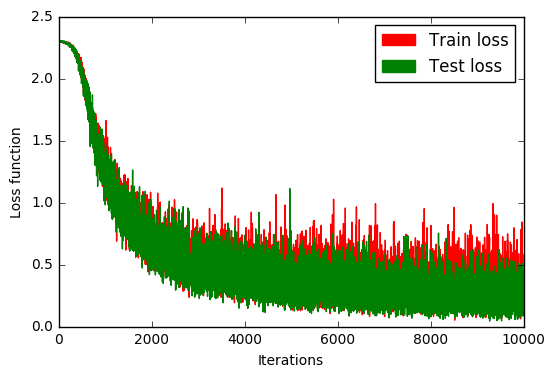

In [37]:
pl.plot(xrange(iters), losses[:, 0], 'r', xrange(iters), losses[:, 1], 'g', alpha = 0.8)
pl.xlabel("Iterations")
pl.ylabel("Loss function")
red_patch = mpatches.Patch(color='red', label='Train loss')
green_patch = mpatches.Patch(color='green', label='Test loss')
pl.legend(handles=[red_patch, green_patch])

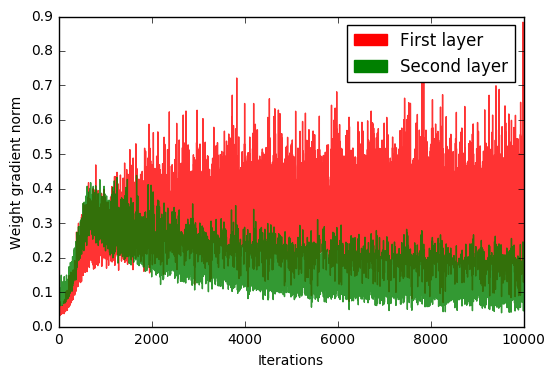

In [38]:
pl.plot(xrange(iters), norms[:, 0], 'r', xrange(iters), norms[:, 2], 'g', alpha = 0.8)
pl.xlabel("Iterations")
pl.ylabel("Weight gradient norm")
red_patch = mpatches.Patch(color='red', label='First layer')
green_patch = mpatches.Patch(color='green', label='Second layer')
pl.legend(handles=[red_patch, green_patch])

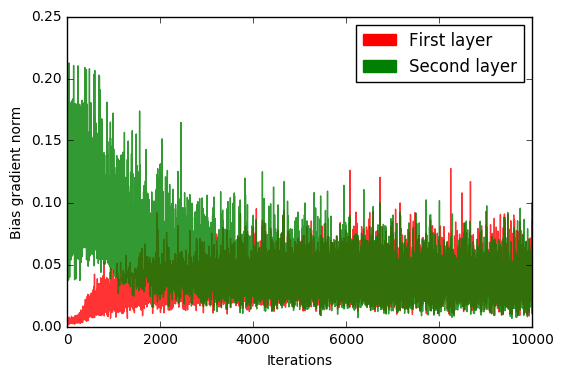

In [39]:
pl.plot(xrange(iters), norms[:, 1], 'r', xrange(iters), norms[:, 3], 'g', alpha = 0.8)
pl.xlabel("Iterations")
pl.ylabel("Bias gradient norm")
red_patch = mpatches.Patch(color='red', label='First layer')
green_patch = mpatches.Patch(color='green', label='Second layer')
pl.legend(handles=[red_patch, green_patch])